<a href="https://colab.research.google.com/github/kimhwijin/korean_food_classifier/blob/master/korean_food_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unzip Dataset

In [6]:
import time

start = time.time()
!unzip -qq "drive/MyDrive/Datasets/kfood.zip"
end = time.time()
print((end-start) // 60, "분...")

6.0 분...


#Clone github

In [1]:
!git clone https://github.com/kimhwijin/korean_food_classifier.git

Cloning into 'korean_food_classifier'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 227 (delta 123), reused 182 (delta 80), pack-reused 0
Receiving objects: 100% (227/227), 8.64 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [1]:
import sys
import os
sys.path.append(os.getcwd() + '/korean_food_classifier')

In [2]:
import kfood_dataset
batch_size = 32
paths = kfood_dataset.get_image_paths()

dataset path : /content/kfood True
saving classes, labels...
saving crop information...
ready!
finding image paths...
shuffling...
paths ready!


# Imports

In [4]:
import tensorflow as tf
from tensorflow import keras

# Make Train, Valid, Test, Dataset

In [5]:
train_set = kfood_dataset.make_kfood_dataset(paths[30000:], n_parse_threads=tf.data.AUTOTUNE, batch_size=batch_size, shuffle_buffer_size=len(paths[30000:]) // batch_size)
valid_set = kfood_dataset.make_kfood_dataset(paths[20000:30000], n_parse_threads=tf.data.AUTOTUNE, batch_size=batch_size, shuffle_buffer_size=10000 // batch_size)
test_set = kfood_dataset.make_kfood_dataset(paths[:20000], n_parse_threads=tf.data.AUTOTUNE, batch_size=None)

# Plot samples

tf.Tensor([[88]], shape=(1, 1), dtype=int64)
tf.Tensor([[16]], shape=(1, 1), dtype=int64)
tf.Tensor([[125]], shape=(1, 1), dtype=int64)
tf.Tensor([[61]], shape=(1, 1), dtype=int64)


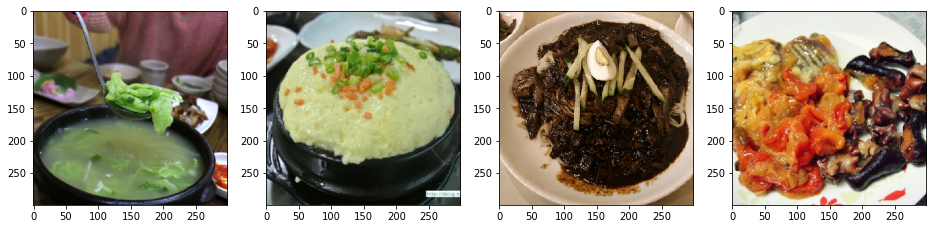

In [6]:
kfood_dataset.plot_dataset_image_4(train_set)

# Model Saver

In [7]:
import datetime
now = datetime.datetime.now()
model_name = 'PretrainedInceptionResNetV2'
model_paths = 'drive/MyDrive/Model/kfood/{}/'
if not os.path.exists(model_paths.format(model_name)):
    os.mkdir(model_paths.format(model_name))


class ModelSaver(keras.callbacks.Callback):
    def __init__(self, now, model_paths,**kwargs):
        self.now = now
        self.model_paths

    def on_epoch_end(self, epoch, logs={}):
        fileformats = [self.now.year, self.now.month, self.now.day, self.now.hour, self.now.minute, epoch]
        self.model.save(self.model_paths + "{}_{}_{}_{}_{}_{}.hd5".format(*fileformats))

# Model Train With Pretrained Model

In [8]:
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=[299,299,3])
avg = keras.layers.GlobalAvgPool2D()(base_model.output)
output = keras.layers.Dense(150, activation='softmax')(avg)

model = keras.models.Model(inputs=[base_model.input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
# freeze
for layer in base_model.layers:
    layer.trainable = False

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [11]:
history = model.fit(train_set, steps_per_epoch=len(paths[30000:])//batch_size,
          validation_data=valid_set, validation_steps=10000 // batch_size, 
          epochs=5)

Epoch 1/5
3765/3765 [==============================] - 789s 201ms/step - loss: 1.9645 - accuracy: 0.5206 - val_loss: 1.5937 - val_accuracy: 0.5800
Epoch 2/5
3765/3765 [==============================] - 751s 199ms/step - loss: 1.5099 - accuracy: 0.6019 - val_loss: 1.5502 - val_accuracy: 0.5931
Epoch 3/5
3765/3765 [==============================] - 753s 200ms/step - loss: 1.4439 - accuracy: 0.6198 - val_loss: 1.5046 - val_accuracy: 0.6044
Epoch 4/5
3765/3765 [==============================] - 750s 199ms/step - loss: 1.4117 - accuracy: 0.6307 - val_loss: 1.4977 - val_accuracy: 0.6137
Epoch 5/5
3765/3765 [==============================] - 754s 200ms/step - loss: 1.3901 - accuracy: 0.6347 - val_loss: 1.4925 - val_accuracy: 0.6098


In [14]:
#save connacted pretrained and new model
now = datetime.datetime.now()
fileformats = [now.year, now.month, now.day, now.hour, now.minute]
model.save(model_paths + "stem_{}_{}_{}_{}_{}.hd5".format(*fileformats))

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/PretrainedInceptionResNetV2/stem_2022_1_31_9_40.hd5/assets


In [ ]:
model = keras.models.load_model(model_paths + "stem_{}_{}_{}_{}_{}.hd5".format(*fileformats))

In [20]:
model.evaluate(valid_set, steps=10000 // 32)

312/312 [==============================] - 64s 191ms/step - loss: 1.4889 - accuracy: 0.6132


[1.4888681173324585, 0.6131811141967773]

In [15]:
#release
for layer in base_model.layers:
    layer.trainable = True

In [12]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_set, steps_per_epoch=len(paths[30000:])//batch_size,
          validation_data=valid_set, validation_steps=10000 // batch_size, 
          epochs=40,
          callbacks=[ModelSaver(datetime.now(), model_paths.format(model_name))]
          )

In [ ]:
import kfood_model
model = kfood_model.make_InceptionResNetV2()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 stem (Stem)                 (None, 35, 35, 384)       604256    
                                                                 
 inception_res_net_a (Incept  (None, 35, 35, 384)      287424    
 ionResNetA)                                                     
                                                                 
 inception_res_net_a_1 (Ince  (None, 35, 35, 384)      287424    
 ptionResNetA)                                                   
                                                                 
 inception_res_net_a_2 (Ince  (None, 35, 35, 384)      287424    
 ptionResNetA)                                                   
                                                             

In [ ]:
import datetime
now = datetime.datetime.now()
model_name = 'InceptionResNetV2'
model_paths = 'drive/MyDrive/Model/kfood/{}/'.format(model_name)
if not os.path.exists(model_paths):
    os.mkdir(model_paths)


class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        fileformats = [now.year, now.month, now.day, now.hour, now.minute, epoch]
        self.model.save(model_paths + "{}_{}_{}_{}_{}_{}.hd5".format(*fileformats))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [ ]:
history = model.fit(train_set, epochs=30, steps_per_epoch=4700, callbacks=[CustomSaver()])

Epoch 1/30
4700/4700 [==============================] - ETA: 0s - loss: 4.9379 - accuracy: 0.0136

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_0.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_0.hd5/assets


4700/4700 [==============================] - 3208s 670ms/step - loss: 4.9379 - accuracy: 0.0136
Epoch 2/30
4700/4700 [==============================] - ETA: 0s - loss: 4.5498 - accuracy: 0.0314

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_1.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_1.hd5/assets


4700/4700 [==============================] - 3149s 670ms/step - loss: 4.5498 - accuracy: 0.0314
Epoch 3/30
4700/4700 [==============================] - ETA: 0s - loss: 4.3236 - accuracy: 0.0508

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_2.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_2.hd5/assets


4700/4700 [==============================] - 3155s 671ms/step - loss: 4.3236 - accuracy: 0.0508
Epoch 4/30
4700/4700 [==============================] - ETA: 0s - loss: 4.2363 - accuracy: 0.0644

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_3.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_3.hd5/assets


4700/4700 [==============================] - 3156s 671ms/step - loss: 4.2363 - accuracy: 0.0644
Epoch 5/30
4700/4700 [==============================] - ETA: 0s - loss: 4.2165 - accuracy: 0.0695

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_4.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_4.hd5/assets


4700/4700 [==============================] - 3156s 671ms/step - loss: 4.2165 - accuracy: 0.0695
Epoch 6/30
4700/4700 [==============================] - ETA: 0s - loss: 4.1376 - accuracy: 0.0788

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_5.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_5.hd5/assets


4700/4700 [==============================] - 3154s 671ms/step - loss: 4.1376 - accuracy: 0.0788
Epoch 7/30
4700/4700 [==============================] - ETA: 0s - loss: 4.0750 - accuracy: 0.0898

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_6.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_6.hd5/assets


4700/4700 [==============================] - 3154s 671ms/step - loss: 4.0750 - accuracy: 0.0898
Epoch 8/30
4700/4700 [==============================] - ETA: 0s - loss: 4.1340 - accuracy: 0.0972

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_7.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_7.hd5/assets


4700/4700 [==============================] - 3155s 671ms/step - loss: 4.1340 - accuracy: 0.0972
Epoch 9/30
4700/4700 [==============================] - ETA: 0s - loss: 3.9954 - accuracy: 0.1109

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_8.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_8.hd5/assets


4700/4700 [==============================] - 3153s 671ms/step - loss: 3.9954 - accuracy: 0.1109
Epoch 10/30
4700/4700 [==============================] - ETA: 0s - loss: 3.8827 - accuracy: 0.1161

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_9.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_9.hd5/assets


4700/4700 [==============================] - 3155s 671ms/step - loss: 3.8827 - accuracy: 0.1161
Epoch 11/30
4700/4700 [==============================] - ETA: 0s - loss: 3.8018 - accuracy: 0.1227

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_10.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_10.hd5/assets


4700/4700 [==============================] - 3155s 671ms/step - loss: 3.8018 - accuracy: 0.1227
Epoch 12/30
4700/4700 [==============================] - ETA: 0s - loss: 3.7822 - accuracy: 0.1350

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_11.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_11.hd5/assets


4700/4700 [==============================] - 3151s 670ms/step - loss: 3.7822 - accuracy: 0.1350
Epoch 13/30
4700/4700 [==============================] - ETA: 0s - loss: 3.7958 - accuracy: 0.1362

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_12.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_12.hd5/assets


4700/4700 [==============================] - 3154s 671ms/step - loss: 3.7958 - accuracy: 0.1362
Epoch 14/30
4700/4700 [==============================] - ETA: 0s - loss: 3.7380 - accuracy: 0.1420

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_13.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_13.hd5/assets


4700/4700 [==============================] - 3156s 672ms/step - loss: 3.7380 - accuracy: 0.1420
Epoch 15/30
4700/4700 [==============================] - ETA: 0s - loss: 3.7019 - accuracy: 0.1471

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_14.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_14.hd5/assets


4700/4700 [==============================] - 3149s 670ms/step - loss: 3.7019 - accuracy: 0.1471
Epoch 16/30
4700/4700 [==============================] - ETA: 0s - loss: 3.6522 - accuracy: 0.1526

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_15.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_15.hd5/assets


4700/4700 [==============================] - 3152s 671ms/step - loss: 3.6522 - accuracy: 0.1526
Epoch 17/30
4700/4700 [==============================] - ETA: 0s - loss: 3.7003 - accuracy: 0.1599

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_16.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_16.hd5/assets


4700/4700 [==============================] - 3156s 672ms/step - loss: 3.7003 - accuracy: 0.1599
Epoch 18/30
4700/4700 [==============================] - ETA: 0s - loss: 3.6415 - accuracy: 0.1548

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_17.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_17.hd5/assets


4700/4700 [==============================] - 3156s 671ms/step - loss: 3.6415 - accuracy: 0.1548
Epoch 19/30
4700/4700 [==============================] - ETA: 0s - loss: 3.6092 - accuracy: 0.1653

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_18.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_18.hd5/assets


4700/4700 [==============================] - 3156s 672ms/step - loss: 3.6092 - accuracy: 0.1653
Epoch 20/30
4700/4700 [==============================] - ETA: 0s - loss: 3.9993 - accuracy: 0.1345

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_19.hd5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/InceptionResNetV2/2022_1_30_10_37_19.hd5/assets


4700/4700 [==============================] - 3152s 671ms/step - loss: 3.9993 - accuracy: 0.1345
Epoch 21/30
1265/4700 [=======>......................] - ETA: 37:03 - loss: 3.5415 - accuracy: 0.1681